In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #type:ignore
plt.style.use('dark_background') # dark_background "default
sns.set_context('paper')

%reload_ext autoreload
%autoreload 2

script_dir = f"C:/Users/aabywan/Downloads/Flickr_8k"
# Change to scrip_dir if required.
os.chdir(script_dir)

In [2]:
from sklearn.preprocessing import LabelEncoder
from phaser.utils import load_labelencoders, bin2bool
from phaser.evaluation import MetricMaker, pred_at_threshold
from phaser.plotting import cm_ax
from phaser.evaluation import BitAnalyzer

label_encoders = load_labelencoders(["le_f","le_a","le_t","le_m"], path="./demo_outputs/")
le_f, le_a, le_t, le_m = label_encoders.values()

TRANSFORMS = le_t.classes_
METRICS    = le_m.classes_
ALGORITHMS = le_a.classes_
FIGSIZE    = (5, 3)

df_d = pd.read_csv("./demo_outputs/distances.csv.bz2")
df_h = pd.read_csv("./demo_outputs/hashes.csv.bz2")

# convert the strings to arrays
for _a in ALGORITHMS:
    df_h[_a] = df_h[_a].apply(bin2bool)

Decide which triplet combination to analyse

In [3]:
print(f"Algorithms available\n{np.column_stack([np.arange(0,len(ALGORITHMS),1), ALGORITHMS])}\n")
print(f"Transformations available\n{np.column_stack([np.arange(0,len(TRANSFORMS),1), TRANSFORMS])}\n")
print(f"Metrics available\n{np.column_stack([np.arange(0,len(METRICS),1), METRICS])}\n")

Algorithms available
[['0' 'colour']
 ['1' 'pdq']
 ['2' 'phash']]

Transformations available
[[0 'Border_bw20_bc255.0.0']
 [1 'Border_bw30_bc255.0.0']
 [2 'Flip_Horizontal']
 [3 'orig']]

Metrics available
[['0' 'Cosine']
 ['1' 'Hamming']]



In [4]:
# Create a label encoder for the class labels
le_c = LabelEncoder()
le_c.classes_ = np.array(['Inter (0)','Intra (1)'])

all_the_bits = {}
evaluation_results = []

triplets = np.array(np.meshgrid(
    ALGORITHMS, 
    TRANSFORMS[:-1], 
    METRICS)).T.reshape(-1,3)

print(f"Number of triplets to analyse: {len(triplets)}")

Number of triplets to analyse: 18


In [106]:
#from phaser.evaluation import BitAnalyzer
BA = BitAnalyzer(df_h, le_t)

metrics = []
bitfreq = {}

for triplet in triplets:
    a_s, t_s, m_s = triplet

    # from string to integer label encoding
    a_l = le_a.transform(np.array(a_s).ravel())[0]
    t_l = le_t.transform(np.array(t_s).ravel())[0]
    m_l = le_m.transform(np.array(m_s).ravel())[0]

    # subset the triplet data
    subset = df_d[
        (df_d['algo'] == a_l) & 
        (df_d['metric'] == m_l)].copy()
    
    y_true = subset['class']
    y_sims = subset[t_s]

    mm = MetricMaker(y_true, y_sims, weighted=False)
    tn, fp, fn, tp = mm.get_cm(
        threshold=mm.eer_thresh, 
        normalize='none', 
        breakdown=True)

    _m = [a_s,t_s,m_s,mm.auc,mm.eer_score,mm.eer_thresh,tn, fp, fn, tp]
    _b = BA.fit(subset, mm.y_pred, t_l, a_s)

    metrics.append(_m)
    bitfreq[f"{a_s}_{t_s}_{m_s}"] = _b
    #bitfreq.append(_b)

metrics = np.row_stack(metrics)

cols = ['Algorithm', 'Transform', 'Metric', 'AUC', 'EER', 'Threshold', 'TN','FP','FN','TP']
metrics = pd.DataFrame(metrics, columns=cols)
metrics[metrics.columns[3:]] = metrics[metrics.columns[3:]].astype(float)

In [204]:
from phaser.evaluation import ComputeMetrics
cm = ComputeMetrics(le_f, le_a, le_t, le_m, df_d, df_h, analyse_bits=True, n_jobs=-1, progress_bar=True)
metrics, bitfreq = cm.fit(triplets=triplets, weighted=False)

Triplet: 100%|██████████| 18/18 [00:00<00:00, 11243.11it/s]


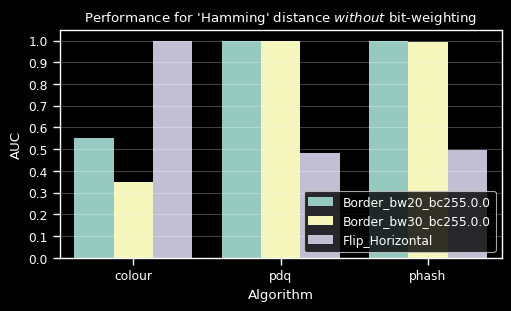

In [205]:
#results.replace([np.inf, -np.inf], 0, inplace=True)
dist_metric='Hamming'
fig, ax = plt.subplots(1,1,figsize=FIGSIZE, constrained_layout=True)
_ = sns.barplot(
    data=metrics[metrics['Metric'] == dist_metric], #type:ignore
    x='Algorithm', 
    y='AUC', 
    hue='Transform',
    ax=ax)
_ = ax.grid(axis='y', alpha=.25)
_ = ax.legend(loc='lower right')
_ = ax.set(
    title=f"Performance for '{dist_metric}' distance $without$ bit-weighting",
    yticks=np.arange(0,1.01,0.1))


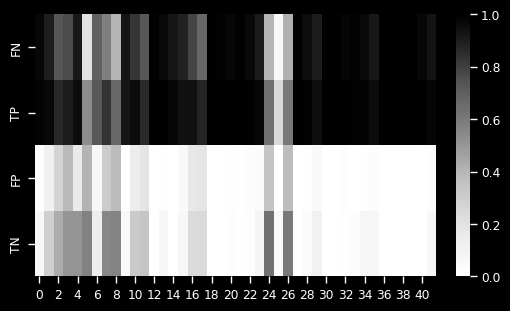

In [206]:
fig, ax = plt.subplots(1,1,figsize=FIGSIZE, constrained_layout=True)
_ = sns.heatmap(bitfreq['colour_Border_bw20_bc255.0.0_Cosine'].T, cmap='Greys', ax=ax)

# Bit-wise analysis

1. Intra-image bits should remain the same
2. Inter-image bits should change

In both cases, the positive outcome is defined as the ```True``` case.

```TP``` = Intra (1) correctly classified as Intra (1)   
```FP``` = Inter (0) falsely classified as Intra (1)   
```TN``` = Inter (0) correctly classfied as Inter (0)     
```FN``` = Intra (1) falsely classified as Inter (0)

# All the bits
Aggregate weights accross different transforms since it is unreal to expect knowing which modifications may have happened to a target image.

Thus, we want weights to work holisticly

In [207]:
mean_weights = {}

for a in ALGORITHMS:
    #if a == 'phash':
        for m in METRICS:
            #if m == 'Hamming':
                pair = f"{a}_{m}"
                _weights = []

                for t in TRANSFORMS:
                    if t == 'orig' : continue
                    bits = bitfreq[f"{a}_{t}_{m}"]
                    means = bits.T.mean().values 
                    _weights.append(means)
                mean_weights[pair] = np.mean(_weights, axis=0)

Apply bit-weighting

In [208]:
from scipy.spatial.distance import hamming
from scipy.spatial.distance import cdist
from tqdm import tqdm

In [209]:
class IntraDistance:
    def __init__(
        self, 
        le_t, 
        le_m, 
        le_a, 
        dist_w=None, # would expect a dicitonary
        distance_metrics={}, 
        set_class=0, 
        progress_bar=False):
        # 
        self.le_t = le_t
        self.le_m = le_m
        self.le_a = le_a
        self.dist_w = dist_w
        self.distance_metrics = distance_metrics
        self.set_class = set_class
        self.progress_bar = progress_bar

        #validate_metrics(self.distance_metrics)

    def intradistance(self, x, algorithm, metric, weights):
        # store the first hash and reshape into 2d array as required by cdist func.
        xa = x[algorithm].iloc[0].reshape(1, -1)

        # row stack the other hashes
        xb = x.iloc[1:][algorithm].values
        xb = np.row_stack(xb)

        # Get the vlaue corresponding to the metric key.
        # This is either a string representing a name from scipy.spatial.distances
        # or a callable function implementing another metric.
        metric_value = self.distance_metrics[metric]
        
        return cdist(xa, xb, metric=metric_value, w=weights)

    def fit(self, data):
        self.files_ = data["filename"].unique()
        self.n_files_ = len(self.files_)

        distances = []

        for a in tqdm(self.le_a.classes_, disable=not self.progress_bar, desc="Hash"):
            for m in self.le_m.classes_:
                
                if self.dist_w:
                    w = self.dist_w[f"{a}_{m}"]
                else: w=None
                
                # Compute the distances for each filename
                grp_dists = data.groupby(["filename"]).apply(
                    self.intradistance, 
                    algorithm=a, 
                    metric=m,
                    weights=w
                )

                # Stack each distance into rows
                grp_dists = np.row_stack(grp_dists)

                # Get the integer labels for algo and metric
                a_label = self.le_a.transform(a.ravel())[0]
                m_label = self.le_m.transform(m.ravel())

                grp_dists = np.column_stack(
                    [
                        self.files_,  # fileA
                        self.files_,  # fileB (same in intra!)
                        np.repeat(a_label, self.n_files_),
                        np.repeat(m_label, self.n_files_),
                        np.repeat(self.set_class, self.n_files_),
                        grp_dists,
                    ]
                )
                distances.append(grp_dists)

        distances = np.concatenate(distances)

        # Create the dataframe output
        cols = ["fileA", "fileB", "algo", "metric", "class", *self.le_t.classes_[:-1]]
        distances = pd.DataFrame(distances, columns=cols)
        distances["orig"] = 0

        # set int columns accordingly
        int_cols = cols[:5]
        distances[int_cols] = distances[int_cols].astype(int)

        # Convert distances to similarities
        sim_cols = distances.columns[5:]
        distances[sim_cols] = 1 - distances[sim_cols]

        return distances
    
distance_metrics = {"Hamming": "hamming", "Cosine": "cosine"}

intra = IntraDistance(
    le_t=le_t,
    le_m=le_m,
    le_a=le_a,
    dist_w=mean_weights,
    distance_metrics=distance_metrics,
    set_class=1,
    progress_bar=True)

intra_df = intra.fit(df_h)
print(f"Number of total intra-image comparisons = {len(intra_df)}")

Hash: 100%|██████████| 3/3 [00:09<00:00,  3.13s/it]

Number of total intra-image comparisons = 48546


In [210]:
from itertools import combinations
from scipy.spatial.distance import pdist

In [211]:
class InterDistance:
    def __init__(
        self,
        le_t,
        le_m,
        le_a,
        dist_w=None,
        distance_metrics={},
        set_class=1,
        n_samples=100,
        random_state=42,
        progress_bar=False,
    ):
        self.le_t = le_t
        self.le_m = le_m
        self.le_a = le_a
        self.dist_w = dist_w
        self.distance_metrics = distance_metrics
        self.set_class = set_class
        self.n_samples = n_samples
        self.random_state = random_state
        self.progress_bar = progress_bar

        #validate_metrics(self.distance_metrics)

    def interdistance(self, x, algorithm, metric, weights):
        # get hashes into a 2d array
        hashes = np.row_stack(x[algorithm])

        # Get the vlaue corresponding to the metric key.
        # This is either a string representing a name from scipy.spatial.distances
        # or a callable function implementing another metric.
        metric_value = self.distance_metrics[metric]

        # return pairwise distances of all combinations
        return pdist(hashes, metric_value, w=weights)

    def fit(self, data):
        # Get the label used to encode 'orig'
        orig_label = self.le_t.transform(np.array(["orig"]).ravel())[0]

        # Assert sufficient data to sample from.
        assert len(data[data["transformation"] == orig_label]) >= self.n_samples

        # Pick the samples
        self.samples_ = (
            data[data["transformation"] == orig_label]
            .sample(self.n_samples, random_state=self.random_state)["filename"]
            .values
        )

        # Subset the data
        subset = data[data["filename"].isin(self.samples_)]

        # Create unique pairs matching the output of scipy.spatial.distances.pdist
        self.pairs_ = np.array(
            [c for c in combinations(subset["filename"].unique(), 2)]
        )

        # Count the number of unique pairs
        self.n_pairs_ = len(self.pairs_)

        # List to hold distances while looping over algorithms and metrics
        distances = []

        # Do the math using Pandas groupby
        for a in tqdm(self.le_a.classes_, disable=not self.progress_bar, desc="Hash"):
            for m in self.le_m.classes_:

                if self.dist_w:
                    w = self.dist_w[f"{a}_{m}"]
                else: w=None
                
                # Compute distances for each group of transformations
                grp_dists = subset.groupby(["transformation"]).apply(
                    self.interdistance,  # type:ignore
                    algorithm=a,
                    metric=m,
                    weights=w
                )

                # Transpose to create rows of observations
                X_dists = np.transpose(np.row_stack(grp_dists.values))

                # Get the integer labels for algo and metric
                a_label = self.le_a.transform(a.ravel())[0]
                m_label = self.le_m.transform(m.ravel())

                # Add columns with pairs of the compared observations
                X_dists = np.column_stack(
                    [
                        self.pairs_,
                        np.repeat(a_label, self.n_pairs_),
                        np.repeat(m_label, self.n_pairs_),
                        np.repeat(self.set_class, self.n_pairs_),
                        X_dists,
                    ]
                )

                # Add the results to the distances array
                distances.append(X_dists)

        # Flatten the distances array
        distances = np.concatenate(distances)

        # Create the dataframe output
        cols = ["fileA", "fileB", "algo", "metric", "class", *self.le_t.classes_]
        distances = pd.DataFrame(distances, columns=cols)

        # Set datatype to int on all non-distance columns
        int_cols = cols[:5]
        distances[int_cols] = distances[int_cols].astype(int)

        # Convert distances to similarities
        sim_cols = distances.columns[5:]
        distances[sim_cols] = 1 - distances[sim_cols]

        return distances

from phaser.similarities import find_inter_samplesize
# Compute the inter distances using subsampling
n_samples = find_inter_samplesize(len(df_h["filename"].unique() * 1))

inter = InterDistance(
    le_t,
    le_m,
    le_a,
    dist_w=mean_weights,
    distance_metrics=distance_metrics,
    set_class=0,
    n_samples=n_samples,
    progress_bar=True,
)
inter_df = inter.fit(df_h)

Hash: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]


In [212]:
df_d_w = pd.concat([intra_df, inter_df])

## Eval

In [213]:
#from phaser.evaluation import BitAnalyzer
#BA = BitAnalyzer(df_h, le_t)

metrics_w = []
#bitfreq_w = {}

for triplet in triplets:
    a_s, t_s, m_s = triplet

    # from string to integer label encoding
    a_l = le_a.transform(np.array(a_s).ravel())[0]
    t_l = le_t.transform(np.array(t_s).ravel())[0]
    m_l = le_m.transform(np.array(m_s).ravel())[0]

    # subset the triplet data
    subset = df_d_w[
        (df_d_w['algo'] == a_l) & 
        (df_d_w['metric'] == m_l)].copy()
    
    y_true = subset['class']
    y_sims = subset[t_s]

    mm = MetricMaker(y_true, y_sims, weighted=False)
    tn, fp, fn, tp = mm.get_cm(
        threshold=mm.eer_thresh, 
        normalize='none', 
        breakdown=True)

    _m = [a_s,t_s,m_s,mm.auc,mm.eer_score,mm.eer_thresh,tn, fp, fn, tp]
    #_b = BA.fit(subset, mm.y_pred, t_l, a_s)

    metrics_w.append(_m)
    #bitfreq_w[f"{a_s}_{t_s}_{m_s}"] = _b
    #bitfreq.append(_b)

metrics_w = np.row_stack(metrics_w)

cols = ['Algorithm', 'Transform', 'Metric', 'AUC', 'EER', 'Threshold', 'TN','FP','FN','TP']
metrics_w = pd.DataFrame(metrics_w, columns=cols)
metrics_w[metrics_w.columns[3:]] = metrics_w[metrics_w.columns[3:]].astype(float)

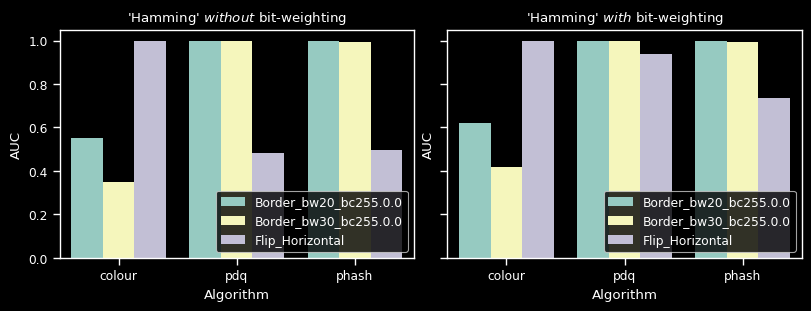

In [203]:
#results.replace([np.inf, -np.inf], 0, inplace=True)
dist_metric='Cosine'
dist_metric='Hamming'
fig, ax = plt.subplots(1,2,figsize=(8,3), constrained_layout=True, sharex=True, sharey=True)
_ = sns.barplot(
    data=metrics[metrics['Metric'] == dist_metric], #type:ignore
    x='Algorithm', 
    y='AUC', 
    hue='Transform',
    ax=ax[0])

_ = sns.barplot(
    data=metrics_w[metrics_w['Metric'] == dist_metric], #type:ignore
    x='Algorithm', 
    y='AUC', 
    hue='Transform',
    ax=ax[1])

#_ = ax.grid(axis='y', alpha=.25)
_ = ax[0].legend(loc='lower right')
_ = ax[1].legend(loc='lower right')
_ = ax[0].set(title=f"'{dist_metric}' $without$ bit-weighting")
_ = ax[1].set(title=f"'{dist_metric}' $with$ bit-weighting")